In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

In [14]:
# Define the Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)

In [16]:
# Define the Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [18]:
# Set random seed for reproducibility
torch.manual_seed(2024)

In [20]:
# Hyperparameters
noise_dim = 128
img_dim = 28 * 28  # Flattened image size for MNIST (28x28)
batch_size = 128
num_epochs = 50
lr = 0.0001

In [22]:
# Instantiate Generator and Discriminator
generator = Generator(noise_dim, img_dim)
discriminator = Discriminator(img_dim)

In [24]:
# Loss function and optimizers
loss_function = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

In [26]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [30]:
# Training loop
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1)
        
        # Labels for real and fake data
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))
        
        # Train Discriminator
        optimizer_d.zero_grad()
        real_loss = loss_function(discriminator(real_imgs), real_labels)
        
        noise = torch.randn(batch_size, noise_dim)
        fake_imgs = generator(noise)
        fake_loss = loss_function(discriminator(fake_imgs.detach()), fake_labels)
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        g_loss = loss_function(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_g.step()
        
        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        noise = torch.randn(batch_size, noise_dim)
        generated_imgs = generator(noise).view(batch_size, 1, 28, 28)
        utils.save_image(generated_imgs, f"generated_images/epoch_{epoch + 1}.png", nrow=8, normalize=True)


Epoch [1/50], Step [0/469], D Loss: 0.1382, G Loss: 3.6492
Epoch [1/50], Step [100/469], D Loss: 0.1610, G Loss: 4.8706
Epoch [1/50], Step [200/469], D Loss: 0.1247, G Loss: 4.0146
Epoch [1/50], Step [300/469], D Loss: 0.1866, G Loss: 6.1832
Epoch [1/50], Step [400/469], D Loss: 0.1649, G Loss: 5.4147
Epoch [2/50], Step [0/469], D Loss: 0.0835, G Loss: 6.4255
Epoch [2/50], Step [100/469], D Loss: 0.2178, G Loss: 5.7976
Epoch [2/50], Step [200/469], D Loss: 0.1355, G Loss: 3.6557
Epoch [2/50], Step [300/469], D Loss: 0.1753, G Loss: 4.6815
Epoch [2/50], Step [400/469], D Loss: 0.1955, G Loss: 5.0904
Epoch [3/50], Step [0/469], D Loss: 0.1705, G Loss: 5.0942
Epoch [3/50], Step [100/469], D Loss: 0.2443, G Loss: 3.9052
Epoch [3/50], Step [200/469], D Loss: 0.2940, G Loss: 5.7441
Epoch [3/50], Step [300/469], D Loss: 0.1766, G Loss: 4.6974
Epoch [3/50], Step [400/469], D Loss: 0.2004, G Loss: 4.6186
Epoch [4/50], Step [0/469], D Loss: 0.1456, G Loss: 5.0091
Epoch [4/50], Step [100/469], D 

In [32]:
# Function to visualize generated images
def visualize_images(images):
    images = images.view(images.size(0), 1, 28, 28)
    grid = utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()

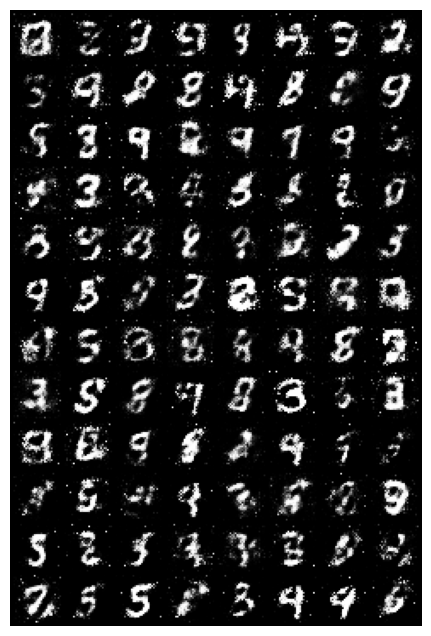

In [34]:
# Visualize generated images
test_noise = torch.randn(batch_size, noise_dim)
generated_images = generator(test_noise)
visualize_images(generated_images)